In [1]:
%%capture

%pip install "tensorflow==2.15.*"
%pip install "tensorflow-text==2.15.*"
%pip install "tf-models-official==2.15.*"
%pip install "tf-keras==2.15.*"
%pip install keras-tuner

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Load datasets

dataset_name = 'ccc-bert-250325-80-aug-2'

autotune = tf.data.AUTOTUNE
batch_size = 32
seed = 42

ds_dir = os.path.join('/kaggle/input', dataset_name)

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

def oneHotLabels(x, y): return x, tf.one_hot(y, depth=len(raw_train_ds.class_names))

train_ds = raw_train_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = raw_val_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'test'),
    batch_size=batch_size)

test_ds = raw_test_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

Found 2076 files belonging to 4 classes.
Using 1661 files for training.
Found 2076 files belonging to 4 classes.
Using 415 files for validation.
Found 507 files belonging to 4 classes.


In [4]:
# Build BERT neural net

epochs = 40

def build_model(hp):
    tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    
    # Hyperparameter tuning
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    l2_rate = hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=5, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=5, sampling='log')
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(4, activation='softmax',
                                kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                                name='classifier')(net)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.metrics.CategoricalAccuracy()
    
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    
    optimizer = optimization.create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')
    
    model = tf.keras.Model(text_input, net)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [5]:
# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_categorical_accuracy',
    max_epochs=10,
    factor=3,
    directory='/kaggle/tmp',
    project_name='ccc_bert_hyperparameter_tuning_adamw'
)

class DiskUsageCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(DiskUsageCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        total, used, free = shutil.disk_usage("/kaggle/tmp")
        if used > self.threshold:
            print(f"Disk usage exceeded threshold: {used} bytes used")
            self.model.stop_training = True

# Define the threshold for disk usage (in bytes)
disk_usage_threshold = 50 * 1024 * 1024 * 1024  # 50 GB

# Create the custom callback
disk_usage_cb = DiskUsageCallback(threshold=disk_usage_threshold)

# Load your training and validation data
# Assuming `train_data` and `val_data` are your preprocessed datasets
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2), disk_usage_cb])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
    Best hyperparameters found:
    - Dropout rate: {best_hps.get('dropout_rate')}
    - L2 regularization: {best_hps.get('l2_rate')}
    - Learning rate: {best_hps.get('learning_rate')}
    """)  

Trial 30 Complete [00h 00m 59s]
val_categorical_accuracy: 0.2795180678367615

Best val_categorical_accuracy So Far: 0.725301206111908
Total elapsed time: 00h 29m 39s

    Best hyperparameters found:
    - Dropout rate: 0.30000000000000004
    - L2 regularization: 0.0001
    - Learning rate: 5e-05
    


In [6]:
# def define_model(dropout_rate, l2_rate, learning_rate):
#     tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
#     tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#     preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
#     encoder_inputs = preprocessing_layer(text_input)
#     encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
#     outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']
#     net = tf.keras.layers.Dropout(dropout_rate)(net)
#     net = tf.keras.layers.Dense(4, activation='softmax',
#                                 kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
#                                 name='classifier')(net)

#     loss = tf.keras.losses.CategoricalCrossentropy()
#     metrics = tf.metrics.CategoricalAccuracy()

#     steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
#     num_train_steps = steps_per_epoch * 20
#     num_warmup_steps = int(0.1*num_train_steps)

#     optimizer = optimization.create_optimizer(
#         init_lr=learning_rate,
#         num_train_steps=num_train_steps,
#         num_warmup_steps=num_warmup_steps,
#         optimizer_type='adamw')
    
#     model = tf.keras.Model(text_input, net)
#     model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
#     return model

In [7]:
# # Tune dropout rate

# def build_model_dropout(hp):
#     dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
#     l2_rate = 0.005
#     learning_rate = 3e-5
#     return define_model(dropout_rate, l2_rate, learning_rate)

# tuner_dropout = kt.Hyperband(
#     build_model_dropout,
#     objective='val_categorical_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='/kaggle/tmp',
#     project_name='ccc_bert_hyperparameter_tuning'
# )

# tuner_dropout.search(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# best_dropout = tuner_dropout.get_best_hyperparameters(num_trials=1)[0].get('dropout_rate')
# print(f'Best dropout rate: {best_dropout}')

# shutil.rmtree('/kaggle/tmp')

In [8]:
# # Tune l2 rate

# def build_model_l2(hp):
#     dropout_rate = best_dropout
#     l2_rate = hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=10, sampling='log')
#     learning_rate = 3e-5
#     return define_model(dropout_rate, l2_rate, learning_rate)

# tuner_l2 = kt.Hyperband(
#     build_model_l2,
#     objective='val_categorical_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='/kaggle/tmp',
#     project_name='ccc_bert_hyperparameter_tuning'
# )

# tuner_l2.search(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# best_l2 = tuner_l2.get_best_hyperparameters(num_trials=1)[0].get('l2_rate')
# print(f'Best l2 rate: {best_l2}')

# shutil.rmtree('/kaggle/tmp')

In [9]:
# # Tune learning rate

# def build_model_lr(hp):
#     dropout_rate = best_dropout
#     l2_rate = best_l2
#     learning_rate = hp.Choice('learning_rate', [1e-5, 2e-5, 3e-5, 5e-5])
#     return define_model(dropout_rate, l2_rate, learning_rate)

# tuner_lr = kt.Hyperband(
#     build_model_lr,
#     objective='val_categorical_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='/kaggle/tmp',
#     project_name='ccc_bert_hyperparameter_tuning'
# )

# tuner_lr.search(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# best_lr = tuner_lr.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
# print(f'Best learning rate: {best_lr}')

# shutil.rmtree('/kaggle/tmp')

In [10]:
# print(f"""
#     Best hyperparameters found:
#     - Dropout rate: {best_dropout}
#     - L2 regularization: {best_l2}
#     - Learning rate: {best_lr}
#     """)

In [11]:
# best_model = define_model(best_dropout, best_l2, best_lr)
best_model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=3, # Number of epochs with no improvement before stopping
    mode='max',  # We want to maximize accuracy
    verbose=1,
    restore_best_weights=True, # Restore the best weights once training stops
    min_delta=0.001)  # Minimum change to qualify as an improvement

training_history = best_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/40
52/52 [==============================] - 46s 606ms/step - loss: 1.5532 - categorical_accuracy: 0.2818 - val_loss: 1.2392 - val_categorical_accuracy: 0.4482
Epoch 2/40
52/52 [==============================] - 30s 584ms/step - loss: 1.2192 - categorical_accuracy: 0.4570 - val_loss: 0.9164 - val_categorical_accuracy: 0.6289
Epoch 3/40
52/52 [==============================] - 30s 584ms/step - loss: 0.9456 - categorical_accuracy: 0.5864 - val_loss: 0.7502 - val_categorical_accuracy: 0.6819
Epoch 4/40
52/52 [==============================] - 30s 584ms/step - loss: 0.6857 - categorical_accuracy: 0.7128 - val_loss: 0.7457 - val_categorical_accuracy: 0.7373
Epoch 5/40
52/52 [==============================] - 30s 584ms/step - loss: 0.3773 - categorical_accuracy: 0.8489 - val_loss: 0.5701 - val_categorical_accuracy: 0.8265
Epoch 6/40
52/52 [==============================] - 30s 584ms/step - loss: 0.1974 - categorical_accuracy: 0.9290 - val_loss: 0.5299 - val_categorical_accuracy: 0.853

In [12]:
loss, accuracy = best_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

16/16 [==============================] - 4s 196ms/step - loss: 2.8229 - categorical_accuracy: 0.6746
Loss: 2.822887659072876
Accuracy: 0.6745561957359314


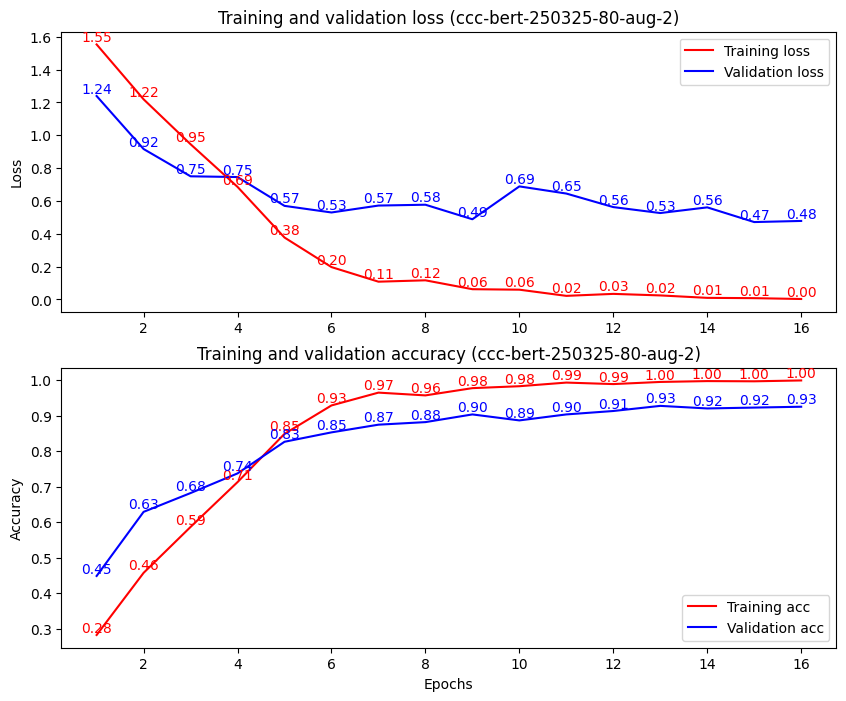

In [13]:
history_dict = training_history.history

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'Training and validation loss ({dataset_name})')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add value labels for loss
for x, y in zip(epochs, loss):
    plt.text(x, y, f"{y:.2f}", color='red', ha='center', va='bottom')
for x, y in zip(epochs, val_loss):
    plt.text(x, y, f"{y:.2f}", color='blue', ha='center', va='bottom')

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'Training and validation accuracy ({dataset_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Add value labels for accuracy
for x, y in zip(epochs, acc):
    plt.text(x, y, f"{y:.2f}", color='red', ha='center', va='bottom')
for x, y in zip(epochs, val_acc):
    plt.text(x, y, f"{y:.2f}", color='blue', ha='center', va='bottom')

figname = f"{dataset_name}-{datetime.now().strftime('%y%m%d-%H%M%S')}.png"
plt.savefig(f"/kaggle/working/{figname}", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Export model for inference
if accuracy > 0.8:
    saved_model_path = '/kaggle/output/{}_model'.format(dataset_name.replace('/', '_'))
    best_model.save(saved_model_path, include_optimizer=False)